<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Problem 1 - Food Classification Model (Individual)</h2><h3>AY2025 Semester</h3></th>
    </tr>
</table>

In [4]:
# Import the Required Packages
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, EfficientNetV2B0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.efficientnet import preprocess_input

import matplotlib.pyplot as plt

2.10.0


## Step 1: Data Loading

In [22]:
# Get current directory
base_dir = os.getcwd()  

# Set paths for train, validation, test folders
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [23]:
# Parameters
img_size = 150
batch_size = 20

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical' # Since there are 10 food classes, we use categorical_crossentropy loss and class_mode='categorical'
)

# Validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


## Step 2:  Develop the Image Classification Models

### Baseline Model

In [4]:
# Load pre-trained VGG16 model without the top classification layers
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

# Freeze the convolutional base layers
conv_base.trainable = False

# Build the baseline model
baseline_model = models.Sequential()
baseline_model.add(conv_base)
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(256, activation='relu'))
baseline_model.add(layers.Dense(10, activation='softmax'))  # 10 food classes so use softmax

#compile
baseline_model.compile(
    loss='categorical_crossentropy',  # since multiclass problem 
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16,814,666
Trainable params: 2,099,978
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
# Train the Model
history_baseline = baseline_model.fit(
    train_generator,
    epochs=10,  
    validation_data=validation_generator
)

Epoch 1/10
375/375 [==============================] - 28s 72ms/step - loss: 1.7620 - acc: 0.4201 - val_loss: 1.4662 - val_acc: 0.5125
Epoch 2/10
375/375 [==============================] - 27s 72ms/step - loss: 1.2612 - acc: 0.5915 - val_loss: 1.2780 - val_acc: 0.5625
Epoch 3/10
375/375 [==============================] - 28s 73ms/step - loss: 1.0851 - acc: 0.6460 - val_loss: 1.2091 - val_acc: 0.5885
Epoch 4/10
375/375 [==============================] - 28s 74ms/step - loss: 0.9786 - acc: 0.6821 - val_loss: 1.1457 - val_acc: 0.6085
Epoch 5/10
375/375 [==============================] - 28s 74ms/step - loss: 0.8983 - acc: 0.7056 - val_loss: 1.1264 - val_acc: 0.6120
Epoch 6/10
375/375 [==============================] - 28s 75ms/step - loss: 0.8371 - acc: 0.7331 - val_loss: 1.0981 - val_acc: 0.6195
Epoch 7/10
375/375 [==============================] - 28s 75ms/step - loss: 0.7825 - acc: 0.7519 - val_loss: 1.0857 - val_acc: 0.6305
Epoch 8/10
375/375 [==============================] - 28s 75ms

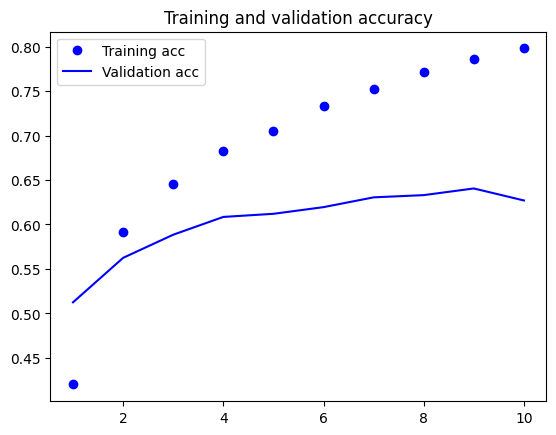

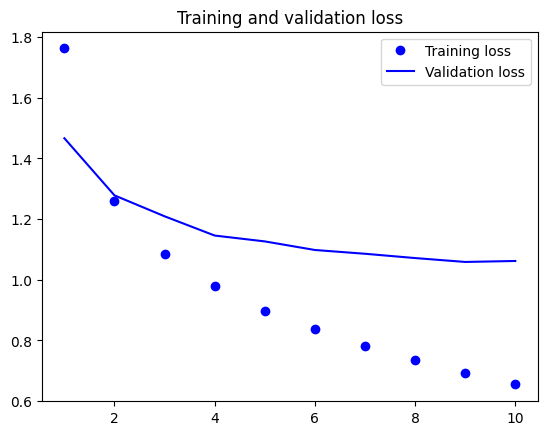

In [6]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history_baseline.history['acc']
val_acc = history_baseline.history['val_acc']
loss = history_baseline.history['loss']
val_loss = history_baseline.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #1: With data augmentation


In [7]:
# Data augmentation for improving generalization and reducing overfitting

# Data augmentation for training set only
augmented_train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

augmented_train_generator = augmented_train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [8]:
# Build model (same as baseline)
augmented_model = models.Sequential()
augmented_model.add(conv_base)
augmented_model.add(layers.Flatten())
augmented_model.add(layers.Dense(256, activation='relu'))
augmented_model.add(layers.Dense(10, activation='softmax'))

# Compile
augmented_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

In [9]:
# Train the Model
history_augmented = augmented_model.fit(
    augmented_train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
375/375 [==============================] - 41s 107ms/step - loss: 1.9317 - acc: 0.3421 - val_loss: 1.5494 - val_acc: 0.4830
Epoch 2/10
375/375 [==============================] - 40s 106ms/step - loss: 1.5127 - acc: 0.4947 - val_loss: 1.3283 - val_acc: 0.5485
Epoch 3/10
375/375 [==============================] - 40s 106ms/step - loss: 1.3879 - acc: 0.5245 - val_loss: 1.2320 - val_acc: 0.5895
Epoch 4/10
375/375 [==============================] - 40s 107ms/step - loss: 1.3038 - acc: 0.5513 - val_loss: 1.1914 - val_acc: 0.5970
Epoch 5/10
375/375 [==============================] - 40s 106ms/step - loss: 1.2510 - acc: 0.5776 - val_loss: 1.1533 - val_acc: 0.6070
Epoch 6/10
375/375 [==============================] - 40s 106ms/step - loss: 1.2147 - acc: 0.5836 - val_loss: 1.1443 - val_acc: 0.6050
Epoch 7/10
375/375 [==============================] - 40s 106ms/step - loss: 1.1867 - acc: 0.5920 - val_loss: 1.1290 - val_acc: 0.6235
Epoch 8/10
375/375 [==============================] - 4

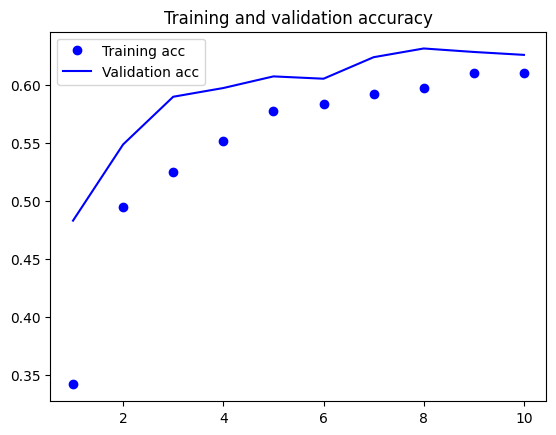

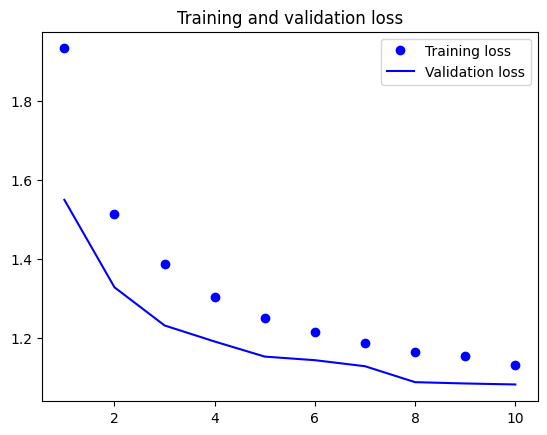

In [10]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history_augmented.history['acc']
val_acc = history_augmented.history['val_acc']
loss = history_augmented.history['loss']
val_loss = history_augmented.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #2: With data augmentation and fine tuning

In [11]:
# Scaling up the model (higher capacity when layers unfrozen)

# Unfreeze conv_base layers for fine-tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Build model
finetuned_model = models.Sequential()
finetuned_model.add(conv_base)
finetuned_model.add(layers.Flatten())
finetuned_model.add(layers.Dense(256, activation='relu'))
finetuned_model.add(layers.Dense(10, activation='softmax'))

finetuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16,814,666
Trainable params: 9,179,402
Non-trainable params: 7,635,264
_________________________________________________________________


In [12]:
finetuned_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5), # reduced learning rate as smaller updates are safer when 
                                                                #  fine-tuning an already well-trained model.
              metrics=['acc'])

history_finetune = finetuned_model.fit(
      augmented_train_generator,
      epochs=10, 
      validation_data=validation_generator)

Epoch 1/10
375/375 [==============================] - 41s 106ms/step - loss: 1.7597 - acc: 0.3908 - val_loss: 1.2858 - val_acc: 0.5565
Epoch 2/10
375/375 [==============================] - 39s 105ms/step - loss: 1.2729 - acc: 0.5576 - val_loss: 1.1308 - val_acc: 0.6130
Epoch 3/10
375/375 [==============================] - 40s 106ms/step - loss: 1.1349 - acc: 0.6068 - val_loss: 1.0781 - val_acc: 0.6275
Epoch 4/10
375/375 [==============================] - 40s 106ms/step - loss: 1.0492 - acc: 0.6395 - val_loss: 1.0018 - val_acc: 0.6555
Epoch 5/10
375/375 [==============================] - 40s 106ms/step - loss: 0.9709 - acc: 0.6683 - val_loss: 0.9451 - val_acc: 0.6650
Epoch 6/10
375/375 [==============================] - 40s 107ms/step - loss: 0.9171 - acc: 0.6795 - val_loss: 0.9316 - val_acc: 0.6835
Epoch 7/10
375/375 [==============================] - 40s 107ms/step - loss: 0.8822 - acc: 0.6987 - val_loss: 0.9380 - val_acc: 0.6765
Epoch 8/10
375/375 [==============================] - 4

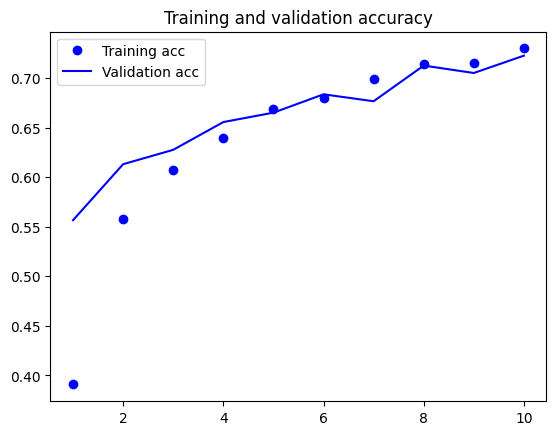

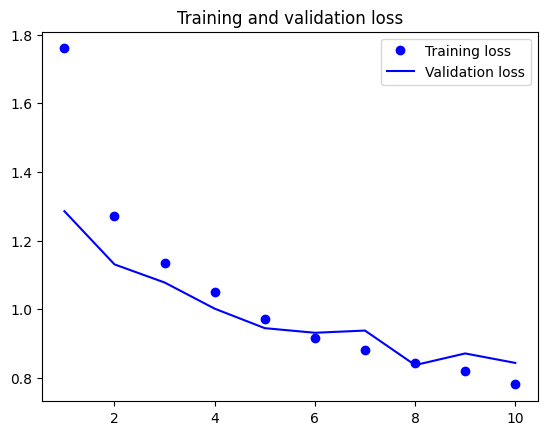

In [13]:
acc = history_finetune.history['acc']
val_acc = history_finetune.history['val_acc']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #3: Scaling up, train until overfit

In [15]:
# Unfreeze the conv_base for fine-tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Build scaled up model
scaled_model = models.Sequential()
scaled_model.add(conv_base)
scaled_model.add(layers.Flatten())
scaled_model.add(layers.Dense(512, activation='relu'))     # increased number of nodes 
scaled_model.add(layers.Dense(256, activation='relu'))     # added layer
scaled_model.add(layers.Dense(10, activation='softmax'))   
scaled_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               4194816   
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dense_11 (Dense)            (None, 10)                2570      
                                                                 
Total params: 19,043,402
Trainable params: 11,408,138
Non-trainable params: 7,635,264
_________________________________________________________________


In [16]:
# Compile
scaled_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)

# Train
history_scaled = scaled_model.fit(
    augmented_train_generator, 
    epochs=20, # increase number of epochs for model to overfit
    validation_data=validation_generator
)

Epoch 1/20
375/375 [==============================] - 41s 107ms/step - loss: 1.2296 - acc: 0.5783 - val_loss: 1.0201 - val_acc: 0.6545
Epoch 2/20
375/375 [==============================] - 40s 107ms/step - loss: 0.9336 - acc: 0.6780 - val_loss: 0.9141 - val_acc: 0.6850
Epoch 3/20
375/375 [==============================] - 40s 107ms/step - loss: 0.8583 - acc: 0.7059 - val_loss: 0.8950 - val_acc: 0.6975
Epoch 4/20
375/375 [==============================] - 40s 106ms/step - loss: 0.8145 - acc: 0.7188 - val_loss: 0.8858 - val_acc: 0.6985
Epoch 5/20
375/375 [==============================] - 40s 106ms/step - loss: 0.7783 - acc: 0.7311 - val_loss: 0.8296 - val_acc: 0.7225
Epoch 6/20
375/375 [==============================] - 40s 107ms/step - loss: 0.7332 - acc: 0.7448 - val_loss: 0.8099 - val_acc: 0.7280
Epoch 7/20
375/375 [==============================] - 40s 106ms/step - loss: 0.7141 - acc: 0.7535 - val_loss: 0.7852 - val_acc: 0.7350
Epoch 8/20
375/375 [==============================] - 4

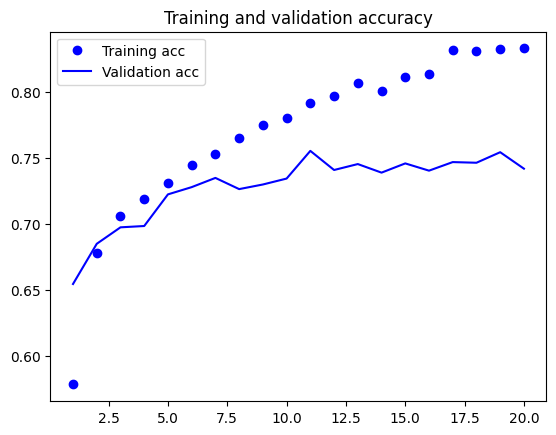

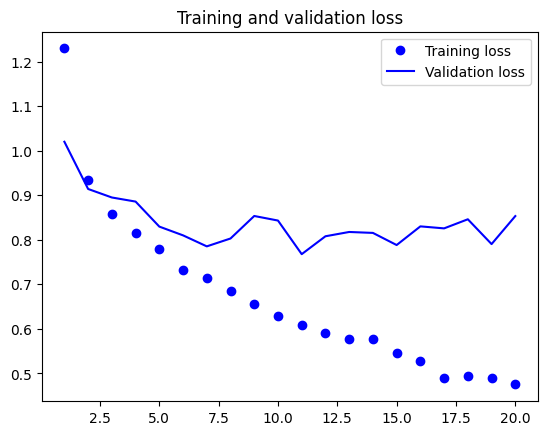

In [17]:
acc = history_scaled.history['acc']
val_acc = history_scaled.history['val_acc']
loss = history_scaled.history['loss']
val_loss = history_scaled.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #4: Regularise the model and tune hyperparameters

In [18]:
# Unfreeze the conv_base for fine-tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

from tensorflow.keras import regularizers

# Build model
regularized_model = models.Sequential()
regularized_model.add(conv_base)
regularized_model.add(layers.Flatten())
regularized_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))) #added l2 regulariser
regularized_model.add(layers.Dropout(0.5)) #added dropout layer
regularized_model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
regularized_model.add(layers.Dropout(0.5))
regularized_model.add(layers.Dense(10, activation='softmax'))

regularized_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_14 (Dense)            (None, 10)               

In [19]:
# Compile
regularized_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)

# Train
history_regularized = regularized_model.fit(
    augmented_train_generator,
    epochs=20, 
    validation_data=validation_generator
)

Epoch 1/20
375/375 [==============================] - 41s 106ms/step - loss: 3.3054 - acc: 0.3072 - val_loss: 2.3982 - val_acc: 0.6510
Epoch 2/20
375/375 [==============================] - 41s 108ms/step - loss: 2.6297 - acc: 0.5224 - val_loss: 2.1437 - val_acc: 0.6860
Epoch 3/20
375/375 [==============================] - 40s 107ms/step - loss: 2.3516 - acc: 0.6131 - val_loss: 2.0375 - val_acc: 0.7220
Epoch 4/20
375/375 [==============================] - 40s 107ms/step - loss: 2.2101 - acc: 0.6451 - val_loss: 1.9711 - val_acc: 0.7285
Epoch 5/20
375/375 [==============================] - 40s 107ms/step - loss: 2.0972 - acc: 0.6840 - val_loss: 1.9444 - val_acc: 0.7335
Epoch 6/20
375/375 [==============================] - 40s 107ms/step - loss: 2.0289 - acc: 0.6993 - val_loss: 1.9188 - val_acc: 0.7370
Epoch 7/20
375/375 [==============================] - 40s 107ms/step - loss: 1.9609 - acc: 0.7115 - val_loss: 1.8879 - val_acc: 0.7430
Epoch 8/20
375/375 [==============================] - 4

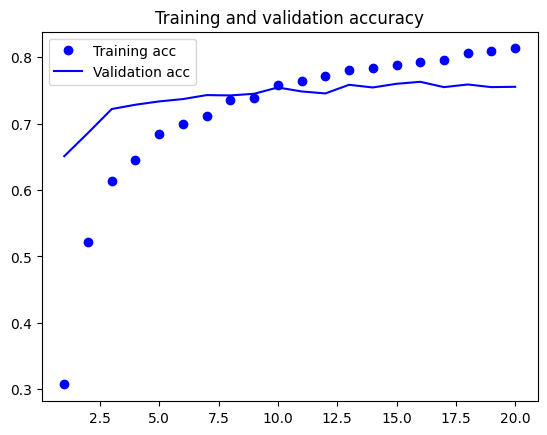

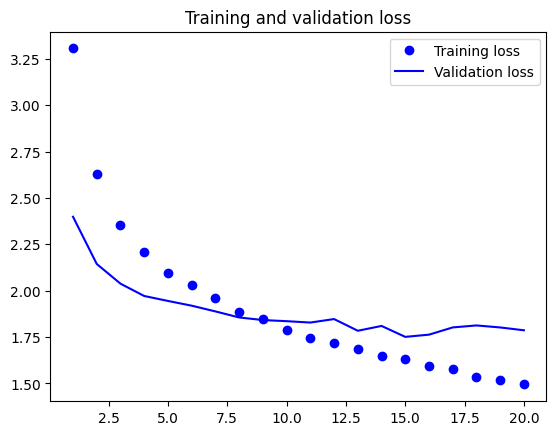

In [20]:
acc = history_regularized.history['acc']
val_acc = history_regularized.history['val_acc']
loss = history_regularized.history['loss']
val_loss = history_regularized.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Since the performance was stable and validation accuracy and loss showed no signs of fluctuation, I decided not to further tune the model, 
# as it was already well-regularised and balanced.

In [64]:
# Save final regularised model from VGG16
regularized_model.save('vgg_model.h5')

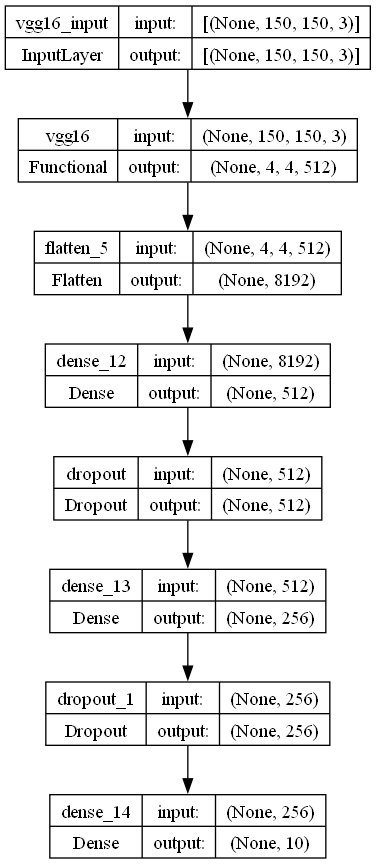

In [5]:
# Load model
vgg_model = keras.models.load_model('vgg_model.h5')
from tensorflow.keras.utils import plot_model
plot_model(vgg_model, show_shapes = True, to_file='model.png')

## Second Model using EfficientNetB0 as pretrained convnet

In [66]:
# Parameters
img_size = 224  # EfficientNet expects 224x224 input
batch_size = 20

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # Using EfficientNet's dedicated preprocessing function
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


### Baseline Model

In [67]:
# Load pre-trained EfficientNet model without the top classification layers
efficientnet_base = EfficientNetV2B0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
# Freeze the convolutional base layers
efficientnet_base.trainable = False

# Build the baseline model
efficientnet_model = models.Sequential()
efficientnet_model.add(efficientnet_base)
efficientnet_model.add(layers.GlobalAveragePooling2D())
efficientnet_model.add(layers.Dense(256, activation='relu')) 
efficientnet_model.add(layers.Dense(10, activation='softmax'))  

# Compile
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

efficientnet_model.summary()

24274472/24274472 [==============================] - 2s 0us/step
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_33 (Dense)            (None, 256)               327936    
                                                                 
 dense_34 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,249,818
Trainable params: 330,506
Non-trainable params: 5,919,312
______________________________________

In [68]:
# Train the Model
history_efficientnet_baseline = efficientnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
375/375 [==============================] - 35s 75ms/step - loss: 1.8473 - acc: 0.4760 - val_loss: 1.3761 - val_acc: 0.7180
Epoch 2/10
375/375 [==============================] - 27s 71ms/step - loss: 1.1005 - acc: 0.7599 - val_loss: 0.8677 - val_acc: 0.7835
Epoch 3/10
375/375 [==============================] - 26s 71ms/step - loss: 0.7670 - acc: 0.7977 - val_loss: 0.6796 - val_acc: 0.8085
Epoch 4/10
375/375 [==============================] - 29s 78ms/step - loss: 0.6306 - acc: 0.8197 - val_loss: 0.5968 - val_acc: 0.8155
Epoch 5/10
375/375 [==============================] - 26s 70ms/step - loss: 0.5594 - acc: 0.8301 - val_loss: 0.5506 - val_acc: 0.8200
Epoch 6/10
375/375 [==============================] - 28s 75ms/step - loss: 0.5171 - acc: 0.8404 - val_loss: 0.5223 - val_acc: 0.8255
Epoch 7/10
375/375 [==============================] - 26s 70ms/step - loss: 0.4834 - acc: 0.8480 - val_loss: 0.5005 - val_acc: 0.8280
Epoch 8/10
375/375 [==============================] - 27s 72ms

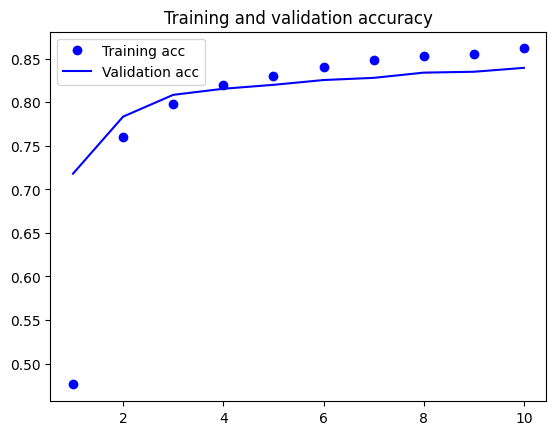

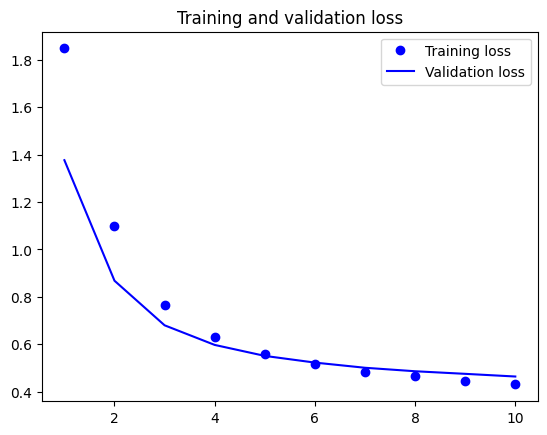

In [71]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history_efficientnet_baseline.history['acc']
val_acc = history_efficientnet_baseline.history['val_acc']
loss = history_efficientnet_baseline.history['loss']
val_loss = history_efficientnet_baseline.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #1: With data augmentation

In [72]:
augmented_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [73]:
# Build the model (same as baseline)
augmented_efficientnet_model = models.Sequential()
augmented_efficientnet_model.add(efficientnet_base)
augmented_efficientnet_model.add(layers.GlobalAveragePooling2D())
augmented_efficientnet_model.add(layers.Dense(256, activation='relu'))
augmented_efficientnet_model.add(layers.Dense(10, activation='softmax'))

# Compile
augmented_efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

In [74]:
# Train the model
history_augmented_efficientnet = augmented_efficientnet_model.fit(
    augmented_train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
375/375 [==============================] - 91s 222ms/step - loss: 1.8561 - acc: 0.4583 - val_loss: 1.2261 - val_acc: 0.6990
Epoch 2/10
375/375 [==============================] - 81s 215ms/step - loss: 0.9628 - acc: 0.7351 - val_loss: 0.6768 - val_acc: 0.8000
Epoch 3/10
375/375 [==============================] - 78s 209ms/step - loss: 0.6701 - acc: 0.7887 - val_loss: 0.5430 - val_acc: 0.8275
Epoch 4/10
375/375 [==============================] - 80s 213ms/step - loss: 0.5721 - acc: 0.8179 - val_loss: 0.4772 - val_acc: 0.8415
Epoch 5/10
375/375 [==============================] - 78s 207ms/step - loss: 0.5011 - acc: 0.8327 - val_loss: 0.4371 - val_acc: 0.8600
Epoch 6/10
375/375 [==============================] - 77s 206ms/step - loss: 0.4572 - acc: 0.8464 - val_loss: 0.4148 - val_acc: 0.8600
Epoch 7/10
375/375 [==============================] - 77s 205ms/step - loss: 0.4212 - acc: 0.8597 - val_loss: 0.4102 - val_acc: 0.8595
Epoch 8/10
375/375 [==============================] - 7

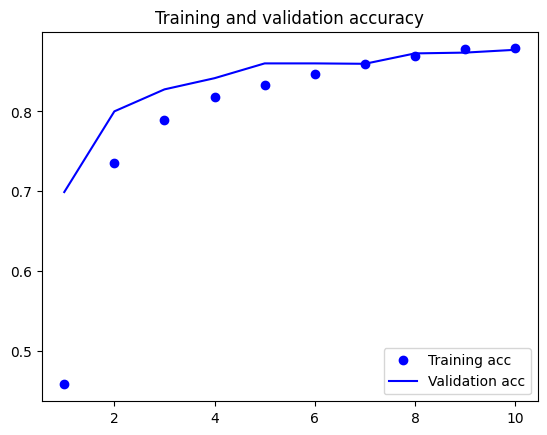

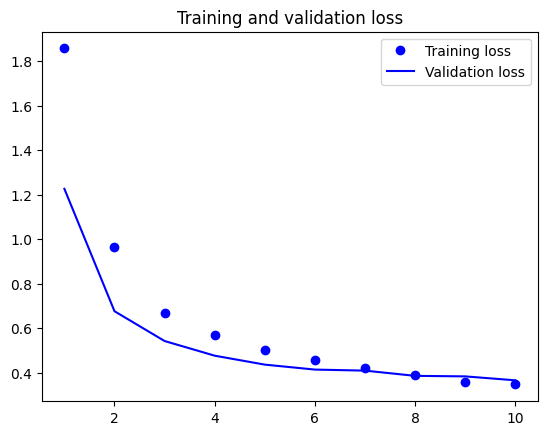

In [75]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history_augmented_efficientnet.history['acc']
val_acc = history_augmented_efficientnet.history['val_acc']
loss = history_augmented_efficientnet.history['loss']
val_loss = history_augmented_efficientnet.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #2: With data augmentation and fine tuning

In [77]:
# Scaling up the model (higher capacity when layers unfrozen)

# Check layers of EfficientNet model to identify which layers to unfreeze
efficientnet_base.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  0          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                  

In [78]:
# Unfreeze conv_base layers for fine-tuning
efficientnet_base.trainable = True

set_trainable = False
for layer in efficientnet_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True # after block6a_expand_conv, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Build model
finetuned_efficientnet_model = models.Sequential()
finetuned_efficientnet_model.add(efficientnet_base)
finetuned_efficientnet_model.add(layers.GlobalAveragePooling2D())  
finetuned_efficientnet_model.add(layers.Dense(256, activation='relu'))
finetuned_efficientnet_model.add(layers.Dense(10, activation='softmax'))

finetuned_efficientnet_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_11  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_43 (Dense)            (None, 256)               327936    
                                                                 
 dense_44 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,249,818
Trainable params: 4,817,206
Non-trainable params: 1,432,612
_________________________________________________________________


In [79]:
finetuned_efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5), # Also reduced learning rate here to avoid destroying useful features learned
    metrics=['acc']
)

# Train the model
history_finetuned_efficientnet = finetuned_efficientnet_model.fit(
    augmented_train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
375/375 [==============================] - 92s 224ms/step - loss: 1.4258 - acc: 0.6595 - val_loss: 0.7426 - val_acc: 0.8555
Epoch 2/10
375/375 [==============================] - 77s 204ms/step - loss: 0.6158 - acc: 0.8495 - val_loss: 0.4674 - val_acc: 0.8660
Epoch 3/10
375/375 [==============================] - 77s 207ms/step - loss: 0.4749 - acc: 0.8559 - val_loss: 0.4160 - val_acc: 0.8735
Epoch 4/10
375/375 [==============================] - 77s 206ms/step - loss: 0.4168 - acc: 0.8691 - val_loss: 0.3904 - val_acc: 0.8755
Epoch 5/10
375/375 [==============================] - 77s 204ms/step - loss: 0.4006 - acc: 0.8680 - val_loss: 0.3871 - val_acc: 0.8820
Epoch 6/10
375/375 [==============================] - 77s 205ms/step - loss: 0.3715 - acc: 0.8776 - val_loss: 0.3745 - val_acc: 0.8815
Epoch 7/10
375/375 [==============================] - 78s 208ms/step - loss: 0.3572 - acc: 0.8775 - val_loss: 0.3691 - val_acc: 0.8825
Epoch 8/10
375/375 [==============================] - 7

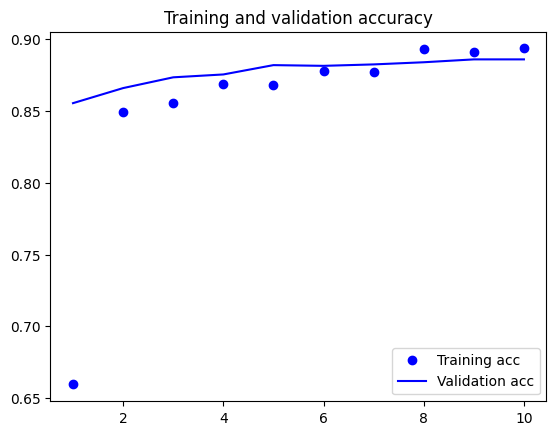

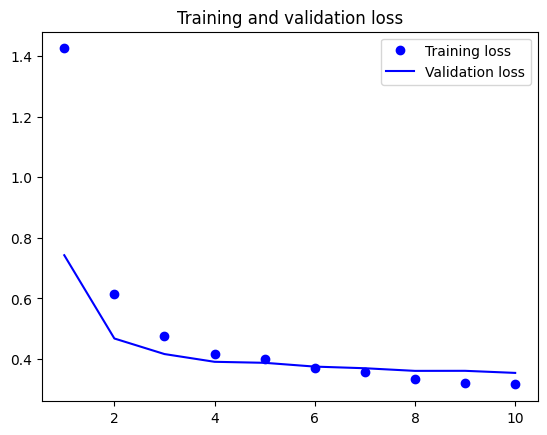

In [80]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history_finetuned_efficientnet.history['acc']
val_acc = history_finetuned_efficientnet.history['val_acc']
loss = history_finetuned_efficientnet.history['loss']
val_loss = history_finetuned_efficientnet.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #3: Scaling up, train until overfit

In [81]:
# Unfreeze the conv_base for fine-tuning
efficientnet_base.trainable = True

set_trainable = False
for layer in efficientnet_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True # after block6a_expand_conv, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Build scaled up model
scaledup_efficientnet_model = models.Sequential()
scaledup_efficientnet_model.add(efficientnet_base)
scaledup_efficientnet_model.add(layers.GlobalAveragePooling2D())
scaledup_efficientnet_model.add(layers.Dense(512, activation='relu'))  # increased number of nodes 
scaledup_efficientnet_model.add(layers.Dense(256, activation='relu'))  # added layer
scaledup_efficientnet_model.add(layers.Dense(10, activation='softmax'))
scaledup_efficientnet_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_12  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_45 (Dense)            (None, 512)               655872    
                                                                 
 dense_46 (Dense)            (None, 256)               131328    
                                                                 
 dense_47 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,709,082
Trainable params: 5,276,470
N

In [82]:
# Compile
scaledup_efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  
    metrics=['acc']
)

# Train 
history_scaledup_efficientnet = scaledup_efficientnet_model.fit(
    augmented_train_generator,
    epochs=20,  # increase number of epochs for model to overfit
    validation_data=validation_generator
)

Epoch 1/20
375/375 [==============================] - 88s 215ms/step - loss: 1.2553 - acc: 0.7452 - val_loss: 0.5309 - val_acc: 0.8730
Epoch 2/20
375/375 [==============================] - 94s 251ms/step - loss: 0.4650 - acc: 0.8755 - val_loss: 0.3705 - val_acc: 0.8875
Epoch 3/20
375/375 [==============================] - 94s 250ms/step - loss: 0.3700 - acc: 0.8809 - val_loss: 0.3571 - val_acc: 0.8870
Epoch 4/20
375/375 [==============================] - 95s 254ms/step - loss: 0.3282 - acc: 0.8943 - val_loss: 0.3555 - val_acc: 0.8905
Epoch 5/20
375/375 [==============================] - 94s 251ms/step - loss: 0.3259 - acc: 0.8904 - val_loss: 0.3491 - val_acc: 0.8840
Epoch 6/20
375/375 [==============================] - 93s 248ms/step - loss: 0.3070 - acc: 0.9013 - val_loss: 0.3427 - val_acc: 0.8910
Epoch 7/20
375/375 [==============================] - 94s 250ms/step - loss: 0.2857 - acc: 0.9040 - val_loss: 0.3492 - val_acc: 0.8885
Epoch 8/20
375/375 [==============================] - 9

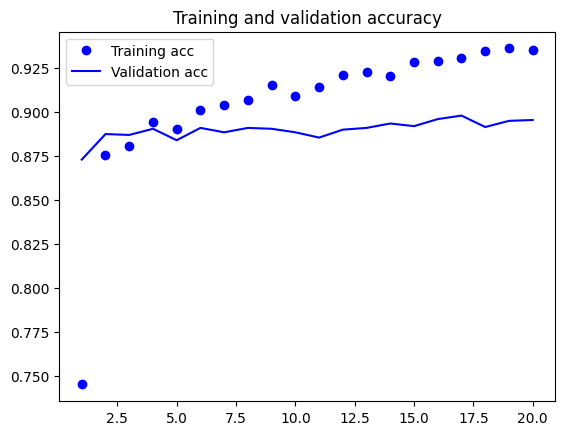

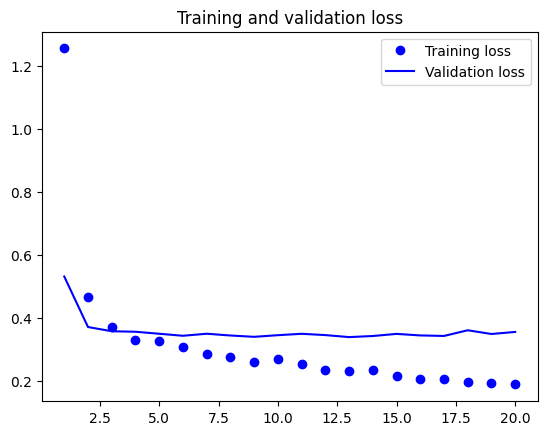

In [83]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history_scaledup_efficientnet.history['acc']
val_acc = history_scaledup_efficientnet.history['val_acc']
loss = history_scaledup_efficientnet.history['loss']
val_loss = history_scaledup_efficientnet.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Improved model #4: Regularise the model and tune hyperparameters

In [84]:
# Unfreeze the conv_base for fine-tuning
efficientnet_base.trainable = True

set_trainable = False
for layer in efficientnet_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True # after block6a_expand_conv, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

regularised_efficientnet_model = models.Sequential()
regularised_efficientnet_model.add(efficientnet_base)
regularised_efficientnet_model.add(layers.GlobalAveragePooling2D())
regularised_efficientnet_model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  #added l2 regulariser
regularised_efficientnet_model.add(layers.Dropout(0.4))  # added dropout layer, lower rate as very mild overfitting
regularised_efficientnet_model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
regularised_efficientnet_model.add(layers.Dropout(0.3))  
regularised_efficientnet_model.add(layers.Dense(10, activation='softmax'))

In [88]:
regularised_efficientnet_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_13  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_48 (Dense)            (None, 512)               655872    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_49 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)             

In [85]:
# Compile
regularised_efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)

# Train
history_regularised_efficientnet = regularised_efficientnet_model.fit(
    augmented_train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
375/375 [==============================] - 110s 270ms/step - loss: 2.7152 - acc: 0.5204 - val_loss: 1.8641 - val_acc: 0.8810
Epoch 2/20
375/375 [==============================] - 98s 261ms/step - loss: 1.7616 - acc: 0.8480 - val_loss: 1.4434 - val_acc: 0.8910
Epoch 3/20
375/375 [==============================] - 99s 265ms/step - loss: 1.4801 - acc: 0.8867 - val_loss: 1.3896 - val_acc: 0.8910
Epoch 4/20
375/375 [==============================] - 99s 264ms/step - loss: 1.3873 - acc: 0.9011 - val_loss: 1.3745 - val_acc: 0.8945
Epoch 5/20
375/375 [==============================] - 98s 262ms/step - loss: 1.3568 - acc: 0.9012 - val_loss: 1.3555 - val_acc: 0.8975
Epoch 6/20
375/375 [==============================] - 97s 258ms/step - loss: 1.3355 - acc: 0.9035 - val_loss: 1.3509 - val_acc: 0.8950
Epoch 7/20
375/375 [==============================] - 97s 258ms/step - loss: 1.2937 - acc: 0.9127 - val_loss: 1.3515 - val_acc: 0.8985
Epoch 8/20
375/375 [==============================] - 

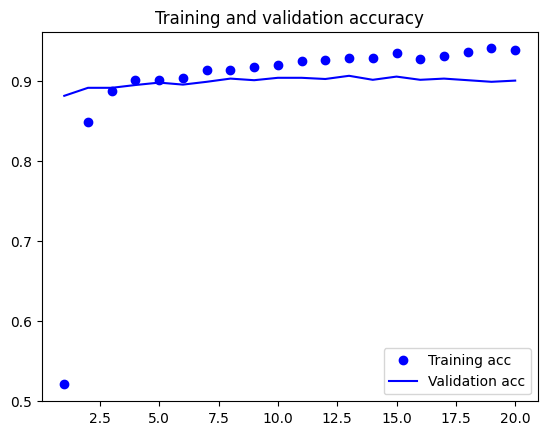

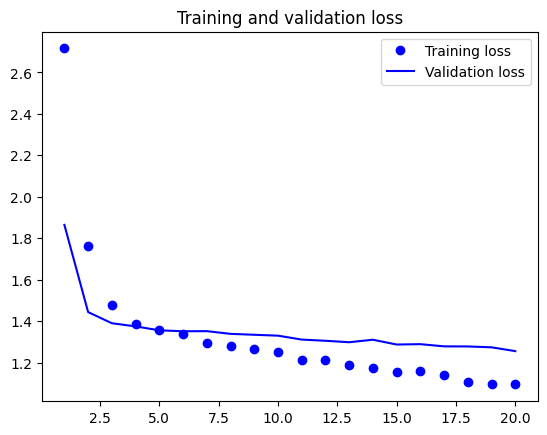

In [86]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history_regularised_efficientnet.history['acc']
val_acc = history_regularised_efficientnet.history['val_acc']
loss = history_regularised_efficientnet.history['loss']
val_loss = history_regularised_efficientnet.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Since this version demonstrated high performance without further fluctuation, I selected this as my final EfficientNet model.

In [87]:
# Save final regularised model with efficientnet
# Save model architecture
regularised_efficientnet_model.save("efficientnetv2_model.h5")

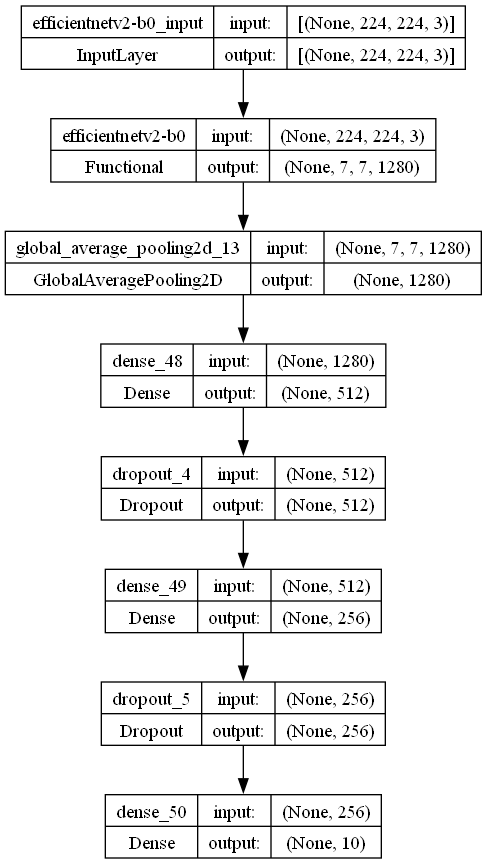

In [6]:
# Load model
efficientnetv2_model = keras.models.load_model('efficientnetv2_model.h5')
from tensorflow.keras.utils import plot_model
plot_model(efficientnetv2_model, show_shapes = True, to_file='model.png')

## Step 3 – Evaluate the Developed Models using Testing Images

In [89]:
vgg_model = keras.models.load_model('vgg_model.h5')
efficientnetv2_model = keras.models.load_model('efficientnetv2_model.h5')

In [90]:
# Parameters for VGG16 Model
img_size = 150
batch_size = 20

# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

In [91]:
# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 500 images belonging to 10 classes.


In [92]:
# Evaluate VGG16 Model
vgg_loss, vgg_acc = vgg_model.evaluate(test_generator)
print(f"VGG Model - Test Accuracy: {vgg_acc:.4f}, Loss: {vgg_loss:.4f}")


25/25 [==============================] - 2s 69ms/step - loss: 1.7216 - acc: 0.7740
VGG Model - Test Accuracy: 0.7740, Loss: 1.7216


In [24]:
# Parameters for EfficientNetV2 model
img_size = 224  
batch_size = 20

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 500 images belonging to 10 classes.


In [94]:
efficientnetv2_loss, efficientnetv2_acc = efficientnetv2_model.evaluate(test_generator)
print(f"EfficientNetV2 Model - Test Accuracy: {efficientnetv2_acc:.4f}, Loss: {efficientnetv2_loss:.4f}")

25/25 [==============================] - 3s 50ms/step - loss: 1.3019 - acc: 0.9040
EfficientNetV2 Model - Test Accuracy: 0.9040, Loss: 1.3019


In [95]:
# Save the best model
# Model that used EfficientNetV2 has significantly higher test acc and lower loss

efficientnetv2_model.save('food_model_best.h5')

In [18]:
# Load the best model
model = keras.models.load_model('food_model_best.h5')

In [31]:
# Generate confusion matrix for best model to see performance across all labels
from sklearn.metrics import confusion_matrix
import numpy as np

# Get actual labels and class names
actual_labels = test_generator.classes   #  numberic indices that correspond to each class name
class_names = list(test_generator.class_indices.keys())

# Predict labels
pred_probs = model.predict(test_generator)   # returns the prediction probabilities for each test image
pred_labels = np.argmax(pred_probs, axis=1)  # np.argmax() picks the index of the highest probability value 

# Compute confusion matrix
cm = confusion_matrix(actual_labels, pred_labels)

# Print confusion matrix
for i, row in enumerate(cm):
    print(f"{class_names[i]:25s} {row}")

25/25 [==============================] - 1s 50ms/step
breakfast_burrito         [45  0  0  0  0  1  0  1  1  2]
carrot_cake               [ 2 40  1  0  1  1  2  0  3  0]
filet_mignon              [ 0  0 45  0  1  0  1  0  3  0]
french_onion_soup         [ 0  0  0 50  0  0  0  0  0  0]
gnocchi                   [ 0  0  1  1 47  0  0  1  0  0]
grilled_cheese_sandwich   [ 2  0  0  0  0 45  0  0  2  1]
macarons                  [ 1  0  0  0  0  0 49  0  0  0]
onion_rings               [ 0  1  0  0  0  1  0 47  0  1]
pork_chop                 [ 0  0  8  0  1  0  0  1 40  0]
pulled_pork_sandwich      [ 3  0  0  0  0  0  0  1  2 44]


## Step 4  – Use the best model to make prediction

In [2]:
# Load the model
model = keras.models.load_model('food_model_best.h5')

In [3]:
# Load the food list (in alphabetical order)
with open('3.txt', 'r') as f: # the .txt file which contains a list of food assigned to you
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

['breakfast_burrito', 'carrot_cake', 'filet_mignon', 'french_onion_soup', 'gnocchi', 'grilled_cheese_sandwich', 'macarons', 'onion_rings', 'pork_chop', 'pulled_pork_sandwich']


In [9]:
# Define some related functions for image process and model prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)
    image_array = preprocess_input(image_array) #uses efficientnet preprocessing
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

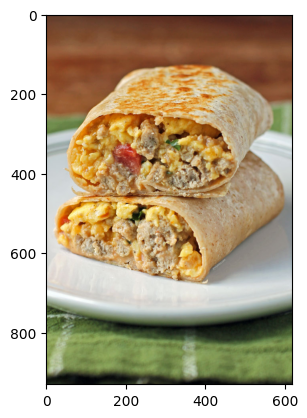

1/1 [==============================] - 0s 40ms/step
The prediction is:  breakfast_burrito 

    breakfast_burrito  carrot_cake  filet_mignon  french_onion_soup   gnocchi  \
0            0.99956     0.000061      0.000047           0.000019  0.000065   

   grilled_cheese_sandwich  macarons  onion_rings  pork_chop  \
0                 0.000015  0.000065     0.000011   0.000009   

   pulled_pork_sandwich  
0              0.000148  


In [10]:
# Make prediction for the image you downloaded from internet (breafast burrito)
import matplotlib.pyplot as plt
img = 'breakfast_burrito.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_size = 224 
img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

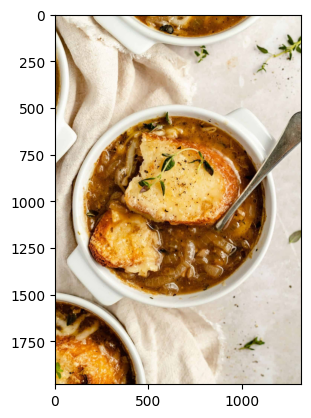

1/1 [==============================] - 0s 37ms/step
The prediction is:  french_onion_soup 

    breakfast_burrito  carrot_cake  filet_mignon  french_onion_soup   gnocchi  \
0           0.000171     0.000006      0.000028           0.999629  0.000052   

   grilled_cheese_sandwich  macarons  onion_rings  pork_chop  \
0                  0.00003  0.000016     0.000025   0.000027   

   pulled_pork_sandwich  
0              0.000016  


In [11]:
# Make prediction for the image you downloaded from internet (french onion soup)
import matplotlib.pyplot as plt
img = 'french_onion_soup.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_size = 224 
img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

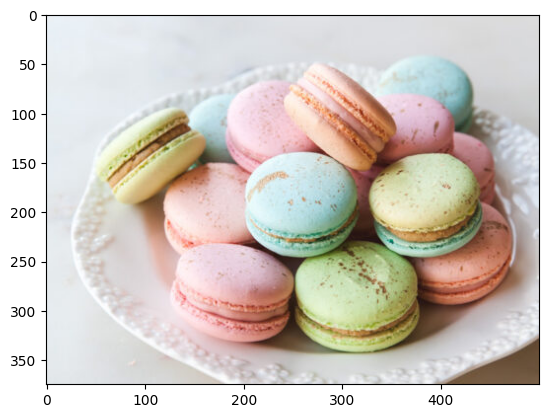

1/1 [==============================] - 0s 31ms/step
The prediction is:  macarons 

    breakfast_burrito   carrot_cake  filet_mignon  french_onion_soup  \
0           0.000001  6.568327e-07  2.049950e-07       9.448323e-07   

        gnocchi  grilled_cheese_sandwich  macarons   onion_rings  \
0  5.168258e-08             1.904029e-07  0.999995  2.584624e-07   

      pork_chop  pulled_pork_sandwich  
0  6.028282e-09              0.000001  


In [12]:
# Make prediction for the image you downloaded from internet (macarons)
import matplotlib.pyplot as plt
img = 'macarons.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_size = 224 
img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

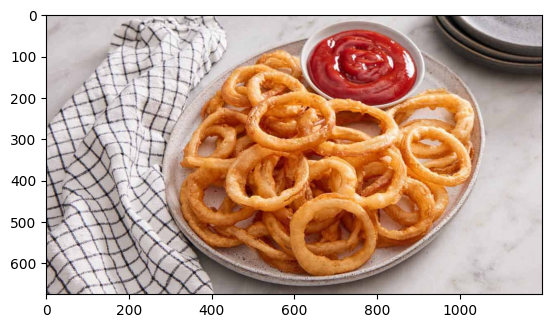

1/1 [==============================] - 0s 36ms/step
The prediction is:  onion_rings 

    breakfast_burrito  carrot_cake  filet_mignon  french_onion_soup   gnocchi  \
0           0.006143     0.001099      0.001661           0.004558  0.001256   

   grilled_cheese_sandwich  macarons  onion_rings  pork_chop  \
0                 0.005653  0.001982     0.974506    0.00045   

   pulled_pork_sandwich  
0              0.002692  


In [13]:
# Make prediction for the image you downloaded from internet (onion ring)
import matplotlib.pyplot as plt
img = 'onion_ring.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_size = 224 
img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

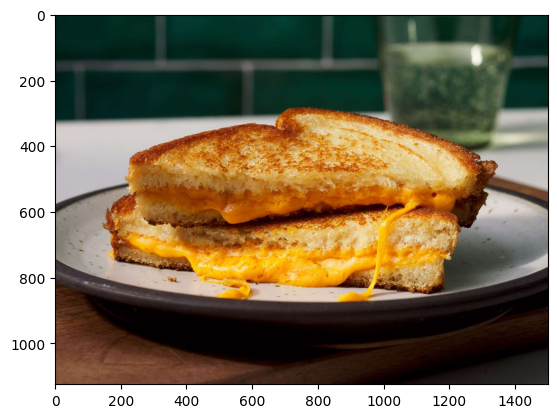

1/1 [==============================] - 0s 33ms/step
The prediction is:  grilled_cheese_sandwich 

    breakfast_burrito   carrot_cake  filet_mignon  french_onion_soup  \
0       3.248647e-07  9.844724e-07  1.037446e-08       6.724105e-07   

        gnocchi  grilled_cheese_sandwich      macarons  onion_rings  \
0  8.753397e-07                 0.999991  4.081773e-07     0.000004   

      pork_chop  pulled_pork_sandwich  
0  2.065397e-07              0.000002  


In [14]:
# Make prediction for the image you downloaded from internet (grilled cheese sandwich)
import matplotlib.pyplot as plt
img = 'grilled_cheese_sandwich.jpg' # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_size = 224 
img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

# Report

## 1. Table of Contents 

#### 2. [Overview](#part1)  
#### 3. [Data Preprocessing and Data Loading](#part2)  
#### 4. [Develop the Image Classification Models](#part3)  
- [4.1 Preliminary Steps Before Model Building ](#part3.1)
- [4.2 Baseline Model with VGG16](#part3.2)
- [4.3 VGG16 + Data Augmentation](#part3.3)
- [4.4 VGG16 with Fine-Tuning (Scaled-Up Model)](#part3.4)
- [4.5 Scaling Up the Model More, until Overfits](#part3.5)
- [4.6 Regularising the model and tuning its hyperparameters](#part3.6)
- [4.7 Switch to EfficientNetV2B0, Base Model](#part3.7)
- [4.8 EfficientNetB0 + Data Augmentation](#part3.8)
- [4.9 EfficientNetB0 with Fine-Tuning](#part3.9)
- [4.10 Scaling Up the Model More, until Overfits](#part3.10)
- [4.11 EfficientNetV2B0 with Regularization](#part3.11)
#### 5. [Evaluate Tuned Model Using Test Images](#part4)  
#### 6. [Use the Model to Perform Classification](#part5)  
#### 7. [Summary](#part6)

## 2. Overview <a id="part1"></a>

The project focuses on an image classification problem, specifically the task of identifying various types of food from images and classifying them. For the project, we are assigned are food list of 10 different types of food to perform the image classification task on. 

The objective of the project is to build an image classification model capable of recognising and classifying food images into one of ten predefined categories with the use of a pretrained model. 

The dataset of images was downloaded from Kaggle and the 10 types of food assigned were extracted using the Jupyter notebook Image_Preprocessing.ipynb that was provided. Image_Preprocessing.ipynb also split the images into a training set (750 images per food) used to train the model, a validation set (200 images per food) used to evaluate the model's performance during the training process and to tune its hyperparameters, and a testing set (50 images per food) used to evaluate the model's performance after training.

To solve this problem, I selected two pre-trained convolution neural networks to use in my model which are VGG16 and EfficientNetV2B0. These networks, previously trained on the large-scale ImageNet dataset and the spatial hierarchy of features learned can effectively act as a generic model.

I developed both models (VGG16 and EfficientNetV2B0) using the universal machine learning workflow. Starting off with a baseline model to set a performance benchmark. Then, scaling up the model until it overfits to give the model more capacity to learn complex patterns which was done by increasing the model's network size and unfreezing parts of the pre-trained ConvNet for fine-tuning. To reduce overfitting and increase generalisation, techniques such as data augmentation and regularisation were applied. Throughout the training process, model performance was carefully monitored using validation accuracy and loss and then the hyperparameters were tuned accordingly.

Both models that were developed to maximise its predictive accuracy were evaluated on the test dataset and the better performing model is then selected to classify real-world food images sourced from the internet. 

By following this structured approach of developing the models, I was able to systematically improve the model's performance while ensuring the model generalizes well to unseen data and not overfit.

## 3. Data Preprocessing and Data Loading <a id="part2"></a>

To prepare the dataset for training, I used the provided Image_Preprocessing notebook to extract the relevant images, split and organise the images. The assignment included a .txt file that listed the exact food types I was to work with. I entered the file name into the notebook, which then automatically filtered and extracted the corresponding image files from the full dataset.

The notebook also split each image file (each corresponding to 1 of the 10 food classes) into three subsets: 750 images per class for training, 200 for validation, and 50 for testing. The images were saved into train, validation, and test folders accordingly.

I proceeded to first set up the directory paths using os.getcwd() and os.path.join() to access each dataset folder then I loaded the data into this notebook and preprocessed it using TensorFlow’s ImageDataGenerator. ImageDataGenerator allows us to quickly set up Python generators that automatically convert image files on disk into batches of preprocessed tensors. 

For the VGG16 model, I applied a simple rescaling preprocessing step (rescale=1./255) to normalize pixel values from the original 0–255 range to 0–1 to stabilizing and accelerating neural network training.

I used the flow_from_directory() method to load the images, where all images were resized to 150 x 150 pixels. The data was organised into batches of 20 images for efficient memory usage during training and the class_mode was set to 'categorical' since it is a multiclass classification task. This was done across train, validation and test datasets.

However, for the EfficientNetV2B0 model, I used its specific preprocessing function: preprocess_input from tensorflow.keras.applications.efficientnet because EfficientNetV2B0 expects inputs to be normalized in a specific way matching its ImageNet training. Additionally, images were resized to 224 x 224 pixels as that is what EfficientNetV2B0 expect the input shape to be. 

## 4. Develop the Image Classification Models <a id="part3"></a>

### 4.1 Preliminary Steps Before Model Building <a id="part3.1"></a>

Before developing the baseline model, there are still some additional things to consider in the universal machine learning workflow:

Defining the Problem and Assembling the Dataset
<br>This was a multiclass classification problem where the objective was to predict one of ten possible food categories based on image inputs. Inputs were colored images of the foods from the categories, and outputs were the class labels such as "carrot cake" or "pulled pork sandwich." The assumption was that the outputs could be predicted from the inputs and that the available labeled images were informative enough to learn the input-output relationship.

Choosing a Measure of Success
<br>Since it is a classification problem, the metric chosen was accuracy.

Deciding on an Evaluation Protocol
<br>This was automatically done by the provided Image_Preprocessing notebook where a hold-out validation set was maintained (200 images per class) as the dataset was moderately large (1000 images per class)

Preparing the Data
<br>This was done in the previous step

### 4.2 Baseline Model with VGG16 <a id="part3.2"></a>

To begin, I developed a baseline model using the VGG16 pre-trained network. I loaded the model with include_top=False and frozen convolutional layers to retain ImageNet-learned features. Then, I appended a Flatten() layer, followed by a FC Dense(256, relu) layer, and an output layer with Dense(10, softmax) to match the 10 food categories. The last layer activation function for a multiclass, single-label classification is softmax and the loss function is categorical_crossentropy. I have selected RMSprop with learning_rate = 2e-5 as my optimiser.

This baseline model performed decently on validation data, reaching an accuracy of around 0.64. However, there was significant overfitting as the training accuracy continued to increase to 0.80 on epoch 10. The loss curves also indicate the same with quite severe overfitting. The loss curves mirrored the accuracy curves in an opposite trend — as training and val accuracy increased, training and val loss decreased.

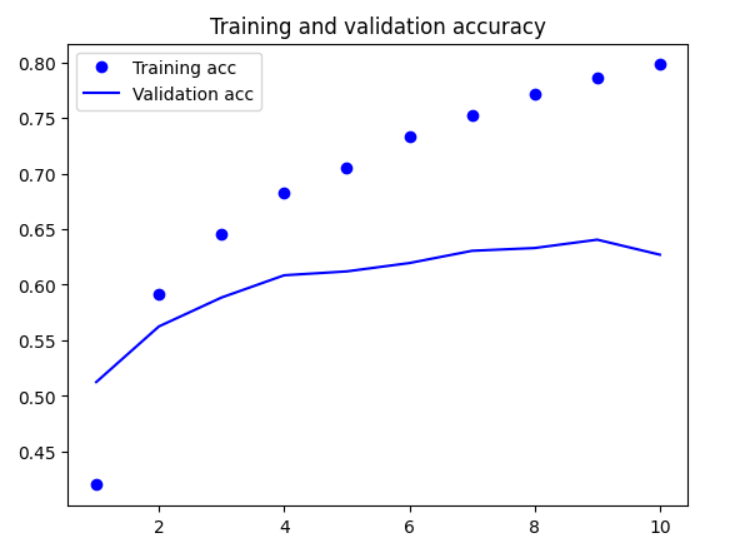

### 4.3 VGG16 + Data Augmentation <a id="part3.3"></a>

To increase generalisation and reduce the overfitting, I implemented data augmentation using ImageDataGenerator, applying transformations such as random rotation, width/height shift, zoom, and horizontal flip, using the same baseline model.

This augmented model slightly underperformed the baseline. The validation accuracy dropped a little to 0.63, but it eliminated overfitting completely where the training and validation curves are very close to each other, reaching around the same accuracy at epoch 10. This indicates that data augmentation was effective in making the model more generalizable, although validation accuracy dropped as a result of increased variation in the training data due to augmentation.

The loss curves mirrored the accuracy curves in an opposite trend, showing the same pattern.

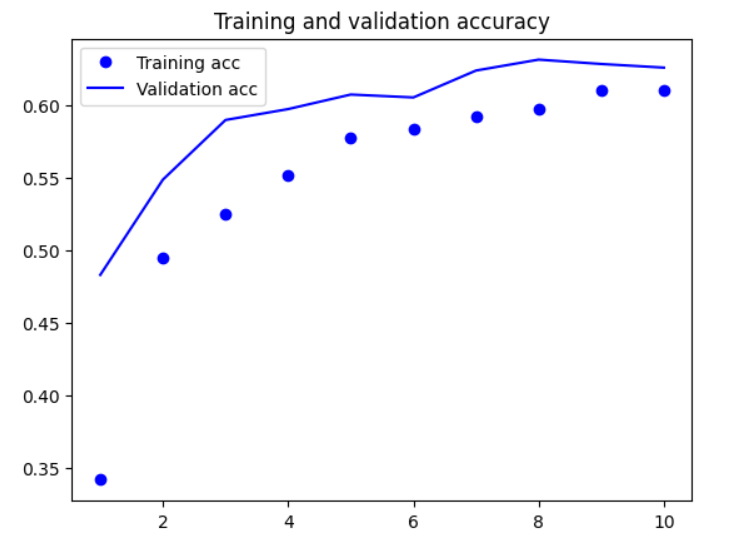

### 4.4 VGG16 with Fine-Tuning (Scaled-Up Model) <a id="part3.4"></a>

Next, I scaled up the model by unfreezing top layers of the VGG16 network, starting from the block5_conv1 layer and jointly training both my FC classifier and these top layers to lightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

By unfreezing these layers, there are more trainable parameters, hence scaling up.

I reduced the learning rate to 1e-5 during fine-tuning which is recommended as to avoid making large updates that could overwrite the useful features the pretrained model had already learned.

This version of the model increased the model performance significantly with the validation accuracy reaching around 0.72 by the 10th epoch without any overfitting. The loss curves mirrored the accuracy curves in an opposite trend, showing the same pattern.

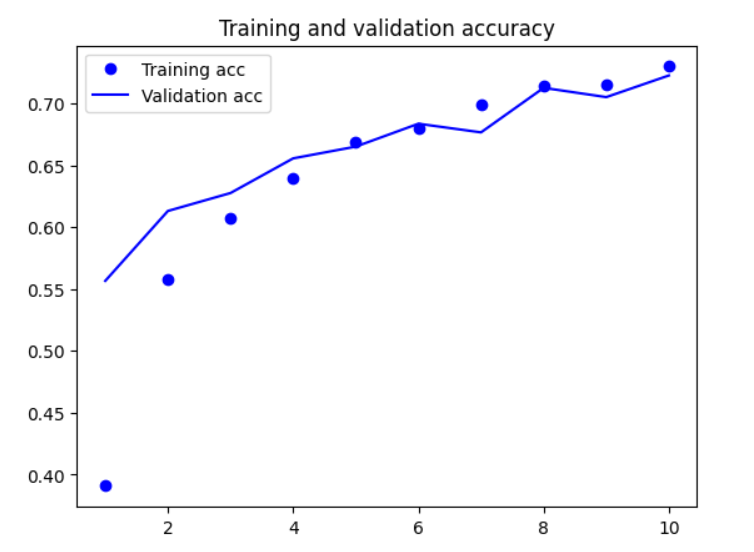

### 4.5 Scaling Up the Model More, until Overfits <a id="part3.5"></a>

Now, I trained the model with more nodes in the first layer, Dense(512, activation='relu') and an additional second layer, Dense(256, activation='relu'. Additionally, I increased the number of epochs to 20 to allow the model to overfit. This increases the capacity of the model to learn more complex patterns.

This version of the model proves to be effective in making the model overfit. Training acc continues to increase beyond 0.80 while val acc experienced diminishing returns at around the 10th epoch. The val accuracy managed to increase from the previous version of the model, reaching around 0.755 on epoch 19. The loss curves mirrored the accuracy curves in an opposite trend, showing the same pattern.

This model gave me a benchmark of the model’s learning limits 

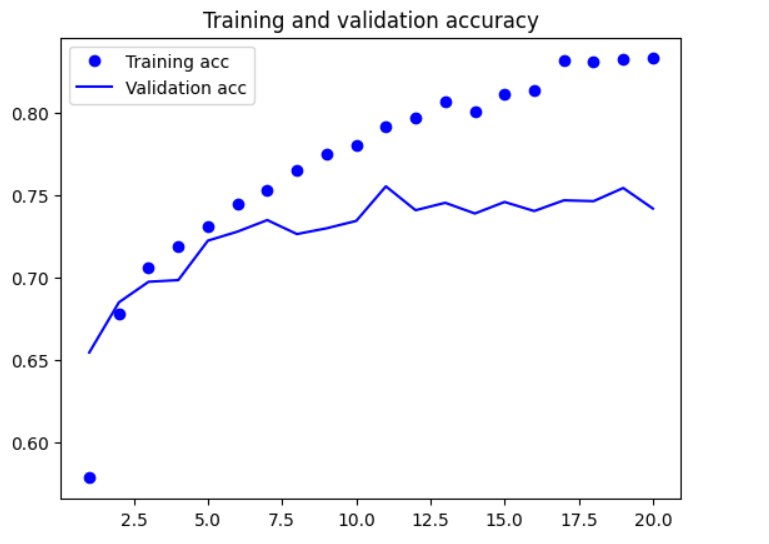

### 4.6 Regularising the model and tuning its hyperparameters <a id="part3.6"></a>

This is the final step of the universal machine learning workflow. To reduce the overfitting from the previous version, I added dropout with a rate of 0.5 and l2 regularisation with strength of 0.001. 

This version managed to reach a val acc of around 0.76 on epoch 18. Since the validation and training curves were close, overfitting from the previous version is eliminated and I decided to not further tune its hyperparameters because the model had already achieved stable performance with minimal validation loss fluctuation and a val acc of 0.76 indicates quite a good model performance, and additional tuning could risk introducing unnecessary complexity or instability. The loss curves mirrored the accuracy curves in an opposite trend, showing the same pattern.

This is my final model using VGG16

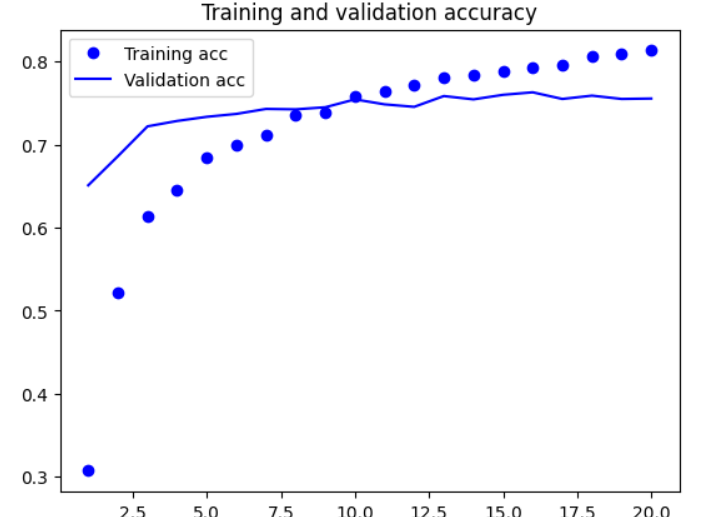

### 4.7 Switch to EfficientNetV2B0, Base Model <a id="part3.7"></a>

I wanted to experiment with other pretrained ConvNets to try and see if I can achieve better model performance. Hence I decided to experiment with a more modern architecture: EfficientNetV2B0.

I used the same model architecture for FC layers used for the VGG16 base model. However, I used GlobalAveragePooling2D instead of Flatten as it is better suited for EfficientNet’s architecture and aligns with how it was originally trained.

EfficientNetV2B0 outperforms VGG16 by a large margin with the base model achieving a very high val acc of 0.84 on epoch 10 without any overfitting as the training curve closely trails behind the validation curve unlike the VGG16 model. The loss curves mirrored the accuracy curves in an opposite trend, showing the same pattern.

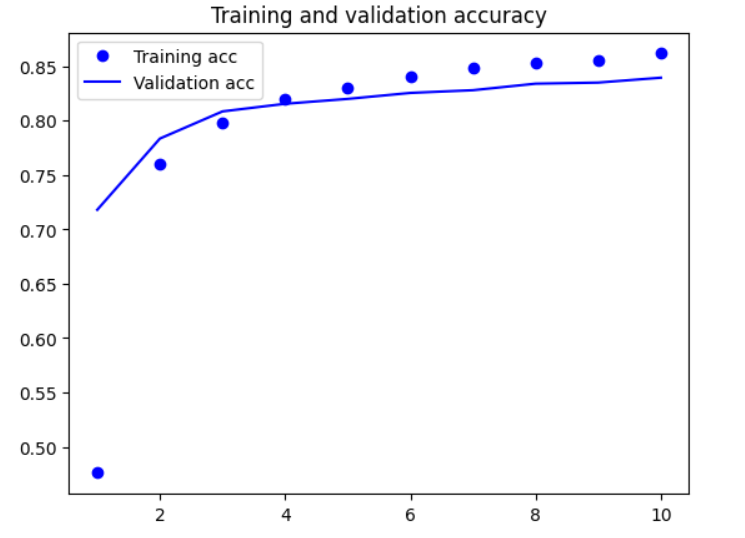

### 4.8 EfficientNetV2B0 + Data Augmentation <a id="part3.8"></a>

I repeated the data augmentation step with EfficientNetB0 using the same transformations.

EfficientNet handled augmentation robustly, and validation acc increased even further to 0.877 on epoch 10, indicating that the model was generalizing well to the augmented images.

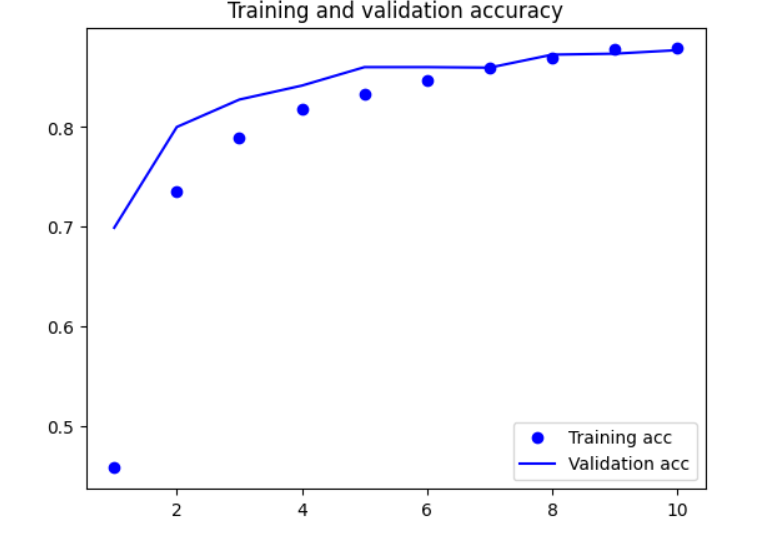

### 4.9 EfficientNetV2B0 with Fine-Tuning <a id="part3.9"></a>

To further boost performance, similar to VGG16, I unfroze the top layers of EfficientNetB0 and reduced the learning rate to 1e-5.

This allowed the model to perform even better with val acc reaching 0.886 on epoch 10 without any overfitting. The loss curves mirrored the accuracy curves in an opposite trend, showing the same pattern.

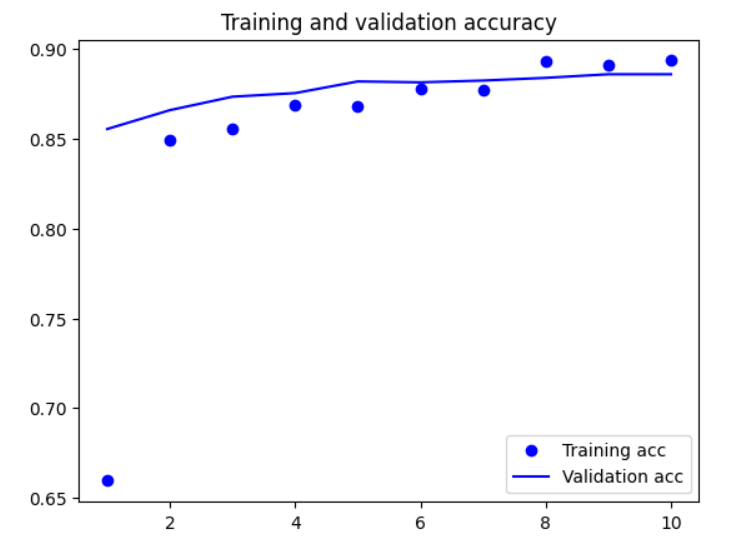

### 4.10 Scaling Up the Model More, until Overfits<a id="part3.10"></a>

Likewise for this EfficientNet Model, I increased the model capacity in the same way I did for VGG16 and also increasing the epochs to 20 to intentionally allow the model to overfit.

This allowed the model to reach a val acc of 0.895, indicating that increasing the capacity for the model to learn more complex features was effective. The model also overfitted slightly where the training accuracy increased beyond 0.925 on epoch 20 while the validation accuracy curve trails behind, increasing very slowly. The loss curves mirrored the accuracy curves in an opposite trend, showing the same pattern..

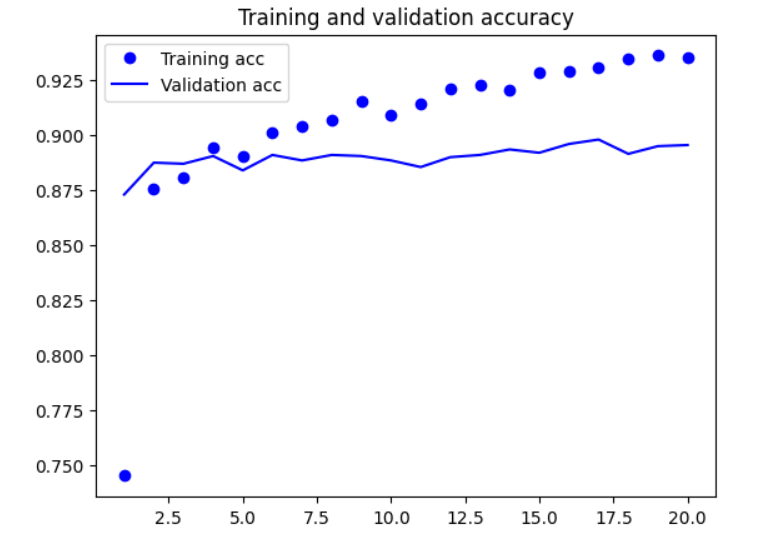

### 4.11 EfficientNetV2B0 with Regularization <a id="part3.11"></a>

To reduce the overfitting from the previous model, I regularised the model in the same way as the model with VGG16 except I reduced the dropout rate to 0.4 and 0.3 as the overfitting for this model is not as severe. 

This helped in reducing overfitting as the gap between the curves became smaller and from the 8th epoch onwards, the model could consistently achieve an accuracy of 0.90. The final EfficientNetV2 model' validation loss gradually decreases from 1.44 in the second epoch to 1.25 on epoch 20, indicating consistent generalization without significant overfitting. Although the validation accuracy plateaued, there was no sharp drop or signs of severe overfitting, hence I tried to avoid any unnecessary retraining and selected this as my final version for the EfficientNetV2B0 model.

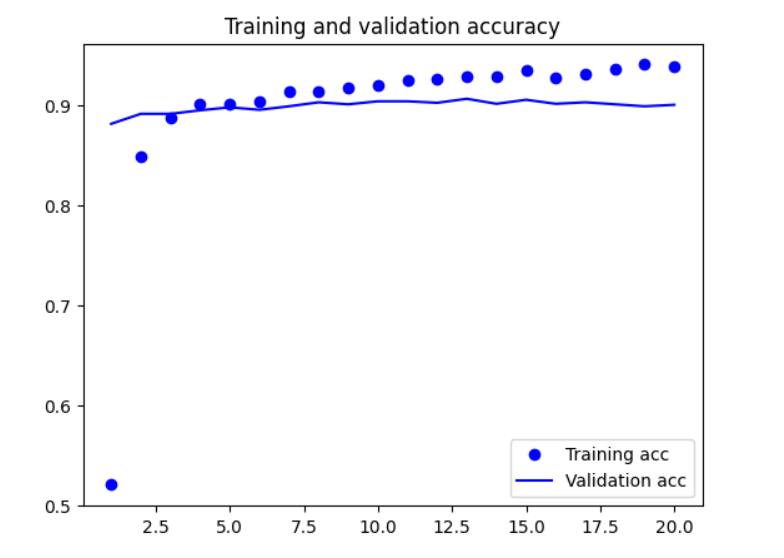

## 5. Evaluate tuned model using Test images <a id="part4"></a>

I used the test generator created with ImageDataGenerator, which included 50 images from each of the 10 food classes, totaling 500 unseen images that were not used during training or validation to be used from the evaluation of both the VGG16 model and the EfficientNetV2B0 model.

Using .evaluate, The VGG16 model achieved a test accuracy of 0.7740 and a loss of 1.7216. Achieving a test accuracy of 77% is quite high and it performed quite decently.

However, he EfficientNetV2 model achieved a much higher test accuracy of 0.9040 and a lower loss of 1.3019, showing that this model is much more superior in terms of its classification performance as it not only have more accurate predictions, but also more confident predictions as indicated by the lower loss.

Based on this comparison, the EfficientNetV2B0 model was selected as the final model due to its higher accuracy and better generalisation ability.

Additionally, to further analyse the better model's (EfficientNetV2B0) performance, I generated a confusion matrix using the test set predictions. This matrix allows a more detailed analysis of how well the model performed on each of the individual food classes. It shows the number of correct and incorrect predictions for each class, making it easier to identify specific categories where the model performs strongly or weakly.

Among the 10 food categories, French Onion Soup achieved the best result with all 50 test images correctly classified. On the other hand, Carrot Cake and Pork Chop had the lowest correct predictions, with only 40 out of 50 images accurately classified. These misclassifications could be due to visual similarities with other classes or less distinctive features. For example, 8 out of the 10 misclassifications for Pork Chop is classified under Filet Mignon which looks similar to it. But overall most food classes were predicted correctly with very high accuracy, showing the model's strong classification performance.

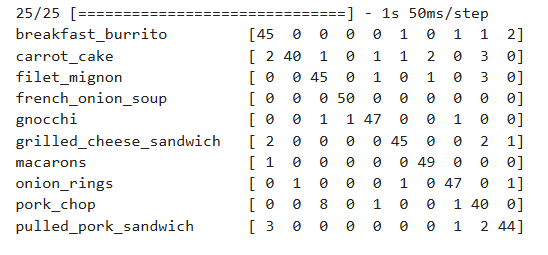

## 6. Use the Model to perform classification <a id="part5"></a>

To apply my trained model on real-world data, I downloaded five food images from the internet that belonged to the 10 food classes I was assigned to, whicha are breakfast_burrito, french_onion_soup, macarons, onion_rings, and grilled_cheese_sandwich. These were unseen images and served as real-life examples to test the model’s generalization capabilities beyond the dataset.

I first loaded the final saved model (food_model_best.h5), along with the sorted food label list from my assigned 3.txt file. Then I used the two functions that were provided, one for preprocessing the image and another for making predictions. 

Each image was reshaped using the image_process() function and passed into the model for prediction using the prediction() function. The model returned a probability distribution across the 10 classes, and the label with the highest probability was selected as the predicted food type.  I repeated this process for each downloaded image and printed out the predicted class alongside the full list of class probabilities for analysis.

All five images were classified correctly, and the model's confidence scores were very high, most above 99% for the correct class and extremely low probabilities for the other classes. For example, the model predicted macarons with 99.999% confidence and french_onion_soup with 99.96% confidence, showing strong reliability.

This testing approach allowed me to confirm that the trained model could be deployed easily in real-world applications.

## 7. Summary <a id="part6"></a>

For this project, I developed two image classification models to recognise 10 types of food using both the pretrained VGG16 and EfficientNetV2 ConvNet. The final VGG16 model achieved quite a good performance with a test accuracy of 77.40%, there was only slight overfitting towards the end but it had a relatively high loss of 1.7216. Hence, the EfficientNetV2 model was developed which greatly outperformed VGG16, achieving a test accuracy of 90.40% and a lower loss of 1.3019, indicating not only more accurate but also more confident predictions.

Among the five real-world food images I downloaded from the internet and tested using the final EfficientNetV2 model, they were all correctly classified, demonstrating that the model was capable of generalizing well to new, unseen data. The confusion matrix from predicting the class labels of the test set also indicated the same, showing high accuracy classification for most classes, with only a few classes such as carrot_cake and pork_chop having lower accuracy.

To further improve, although the final model performed very well, it showed slight overfitting in the later epochs. To address this, I could try and experiment with stopping at earlier epochs by monitoring validation performance or introduced additional regularisation techniques such as increasing dropout rate or L2 regularisation strength. This might help improve the model’s generalisation further. Additionally, testing the model on a larger set of diverse real-world images could allow for better analysis on its performance.